In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

from IPython.display import display, clear_output
import logging
logging.getLogger('tensorflow').disabled = True



In [2]:
def load_bar_color():
    db = np.load("rodsdb.npy")
    db = db.reshape(-1, 10*10)
    return db
    

x_train = load_bar_color()


In [3]:
import sys
from stm.stm import STM, RBF2DInterpolation

# Training a GTM with the GTM object

### Constants and Plots

In [4]:
# Model constants ----

x_train = x_train[:10000]
x_train = 2*x_train/255 - 1
inp_num = x_train.shape[1:]
inp_side = inp_num[0]
out_num = 20**2
out_side = int(np.sqrt(out_num))
initial_lr = 0.3
initial_sigma = out_side
min_sigma =0.7

In [5]:
def gauss(d, s): return np.exp(-0.5*(s**-2)*d**2)

# Scheduling constants ----

x_train = x_train

decay_window = 30.0
data = x_train
data_num = x_train.shape[0]
batches_num = 10
batch_size = data_num // batches_num
epochs = 80
idcs = np.arange(data_num)
inp_width = 10
inp_height = 10
idx=57

### Model

In [6]:
# Model graph ----

dists = keras.layers.Input(shape = [out_num])
stm = STM(out_num, initial_sigma, name="stm")

# the graph for the GTM
inp = keras.layers.Input(shape = inp_num)
stm_out = stm(inp)

model = keras.models.Model(inputs=[inp, dists], outputs=stm_out)
# loss for the som layer. 
# One parameter for an unsupervised-topological map.
model.add_loss(stm.loss(stm_out))

model.compile(optimizer=keras.optimizers.Adam(learning_rate=initial_lr), metrics=None)
model.summary()

@tf.function
def forward_spread(inp):
    return stm(inp)
    
@tf.function
def backward_spread(out):
    inp = stm.backward(out)
    return inp

model.forward_spread = forward_spread
model.backward_spread = backward_spread


Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 400)]        0                                            
__________________________________________________________________________________________________
stm (STM)                       (None, 400)          40001       input_2[0][0]                    
__________________________________________________________________________________________________
tf_op_layer_Shape (TensorFlowOp [(2,)]               0           stm[0][0]                        
_______________________________________________________________________________________

### Training

In [7]:
# iterate epochs ----
losses = []
for epoch in range(epochs):
    np.random.shuffle(idcs)

    # learning rate and sigma annealing
    curr_sigma = initial_sigma*np.exp(-epoch/decay_window)
    curr_rl = initial_lr*np.exp(-epoch/decay_window)
    
    # update learning rate and sigma in the graph 
    keras.backend.set_value(model.get_layer("stm").sigma, curr_sigma)
    keras.backend.set_value(model.optimizer.lr, curr_rl)
    
    # iterate batches ----
    loss = []
    for batch in range(batches_num):
         
        # define current indices
        start_batch = batch * batch_size
        end_batch = (batch + 1) * batch_size
        curr_idcs = idcs[start_batch:end_batch]
        
        # train
        loss_ = model.train_on_batch([data[curr_idcs]])
        loss.append(loss_)

    losses.append(np.mean(loss))
    if epoch % 20 == 0 or epoch == epochs -1:
        clear_output()
        print("epoch: ", epoch)
        print("loss:", losses[epoch])

epoch:  79
loss: 0.012752117589116096


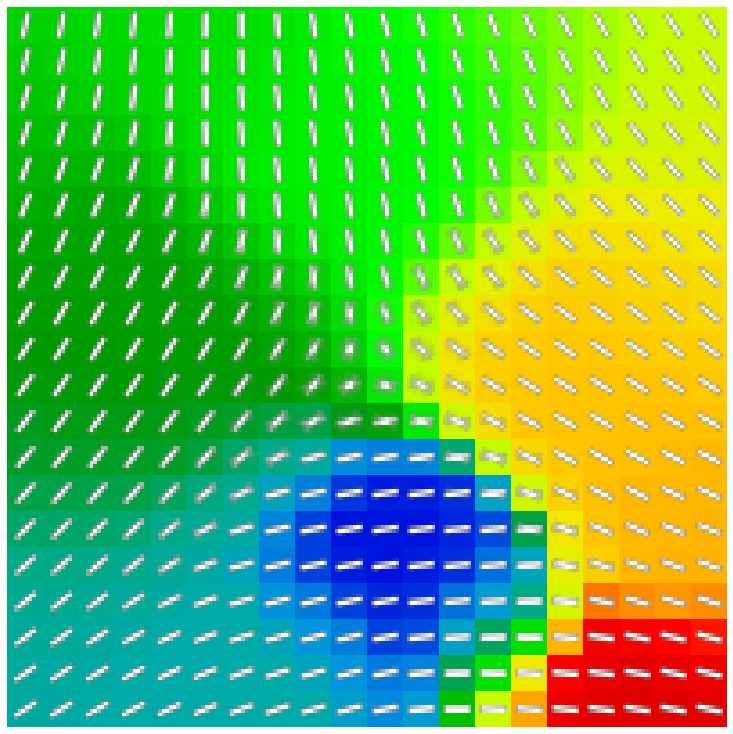

In [15]:
new_model = keras.models.load_model('orientation_model')
weights = model.get_layer('stm').kernel.numpy()
weights.shape
fig = plt.figure(figsize=(10,10))
for i, w in enumerate(weights.T):
    ww = (w - w.min())/(w.max()- w.min())
    ww = ww.reshape(inp_width,inp_height)
    c = new_model.predict(ww.reshape(1,10,10))
    c = plt.cm.nipy_spectral(c*1.2)
    ax = fig.add_subplot(out_side,out_side,i+1)
    ax.imshow(ww.reshape(inp_width, inp_height, 1) *c[0].reshape(1,1,4))
    #ax.imshow(ww)
    ax.set_axis_off()
fig.tight_layout(pad=0.01)
fig.savefig("orientation.png")
    